In [ ]:
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt
import time
import cv2
import random
import math
from PIL import Image
import cupy as cp

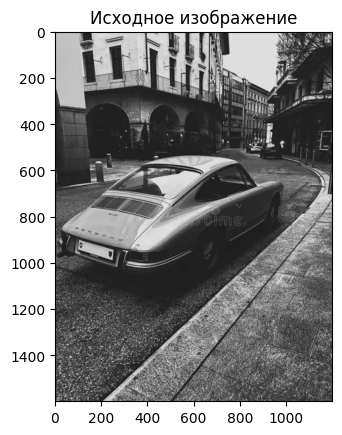

In [48]:
# Загрузка изображения
image = cv2.imread("image_4.bmp", cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.title('Исходное изображение')
image_1 = image.copy()

In [49]:
def bilateral_cpu(image, sigma_r, sigma_d):
  output_img = np.zeros(image.shape)
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      h = 0
      k = 0
      for ik in range(i - 2, i + 3):
        for jk in range(j - 2, j + 3):
          if 0 <= ik < image.shape[0] and 0 <= jk < image.shape[1]:
            x = ik - i
            y = jk - j
            w = math.exp(-((x**2 - y**2)/(sigma_d**2))) * math.exp(((int(image[ik][jk]) - int(image[i][j]))**2)/(sigma_r**2))
            h += image[ik][jk]*w
            k += w
      output_img[i][j] = h/k
  return output_img

Время CPU:  241.17984652519226


Text(0.5, 1.0, 'Изображение после фильтра на CPU')

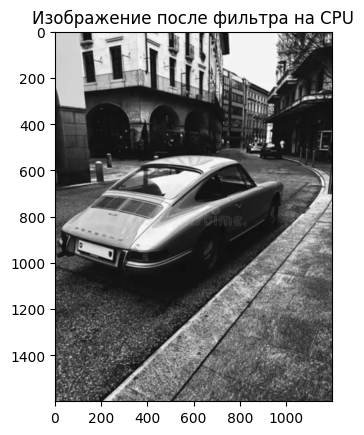

In [50]:
# По мере увеличения параметра диапазона sigma_r билатеральный фильтр постепенно приближается к гауссовской свертке, потому что гауссиан диапазона расширяется и выравнивается,
# что означает, что он становится почти постоянным в интервале интенсивности изображения.
# По мере увеличения пространственного параметра sigma_d более крупные детали сглаживаются.
sigma_r, sigma_d = 900, 1800

start_cpu = time.time()
result_cpu = bilateral_cpu(image, sigma_r, sigma_d)
elapsed_time_cpu = time.time() - start_cpu

print("Время CPU: ", elapsed_time_cpu)
plt.imshow(result_cpu, cmap='gray')
plt.title('Изображение после фильтра на CPU')

In [51]:
@cuda.jit
def bilateral_kern(input_image, output_image, sigma_r, sigma_d):
  i, j = cuda.grid(2)
  if i < input_image.shape[0] and j < input_image.shape[1]:
      h = 0
      k = 0
      for ik in range(i - 2, i + 3):
        for jk in range(j - 2, j + 3):
          if 0 <= ik < image.shape[0] and 0 <= jk < image.shape[1]:
            x = ik - i
            y = jk - j
            w = math.exp(-((x**2 - y**2)/(sigma_d**2))) * math.exp(((int(input_image[ik][jk]) - int(input_image[i][j]))**2)/(sigma_r**2))
            h += input_image[ik][jk]*w
            k += w
      output_image[i][j] = h/k


In [52]:
# Создаем массив для входных и выходных данных на устройстве
input_data = cuda.to_device(image)
output_data = cuda.device_array_like(np.array(image))

# Конфигурация блоков и потоков для выполнения на GPU
threadsperblock = (16, 16)
blockspergrid_x = (np.array(image).shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (np.array(image).shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)

Время на GPU:  0.07909584045410156


Text(0.5, 1.0, 'Изображение после фильтрации на GPU')

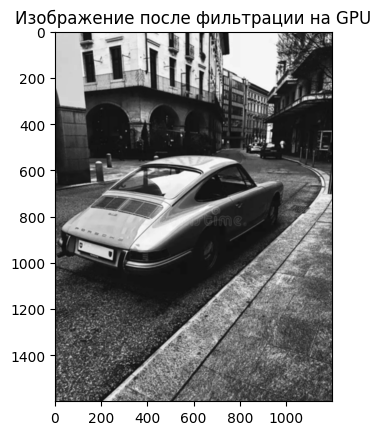

In [54]:
# Замер времени на GPU
start_time_gpu = time.time()

bilateral_kern[blockspergrid, threadsperblock](input_data, output_data, sigma_r, sigma_d)

cp.cuda.Device().synchronize()
end_time_gpu = time.time()
elapsed_time_gpu = end_time_gpu - start_time_gpu

print("Время на GPU: ", elapsed_time_gpu)

result_gpu = output_data.copy_to_host()

plt.imshow(result_gpu, cmap='gray')
plt.title('Изображение после фильтрации на GPU')

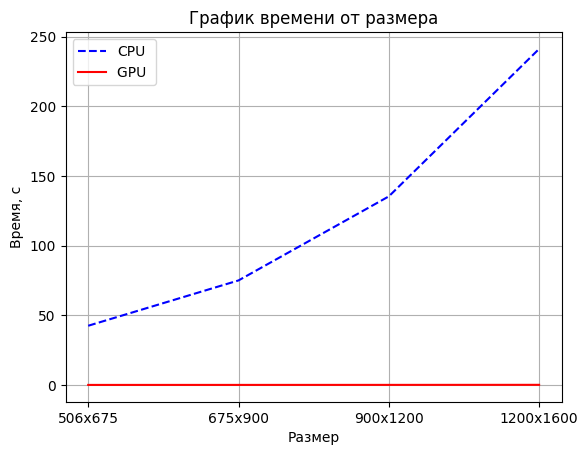

In [55]:
import matplotlib.pyplot as plt
time_cpu = [42.48401737213135, 75.00736570358276, 135.32953715324402, 241.17984652519226]
time_gpu = [0.014828681945800781, 0.02634596824645996, 0.044519901275634766, 0.07909584045410156]
size = ['506x675', '675x900', '900x1200', '1200x1600']
plt.title('График времени от размера')
plt.xlabel('Размер')
plt.ylabel('Время, с')
plt.plot(size,time_cpu,'b--',size,time_gpu,'red')
plt.legend(['CPU','GPU '], loc=2)
plt.grid(True)
plt.show()

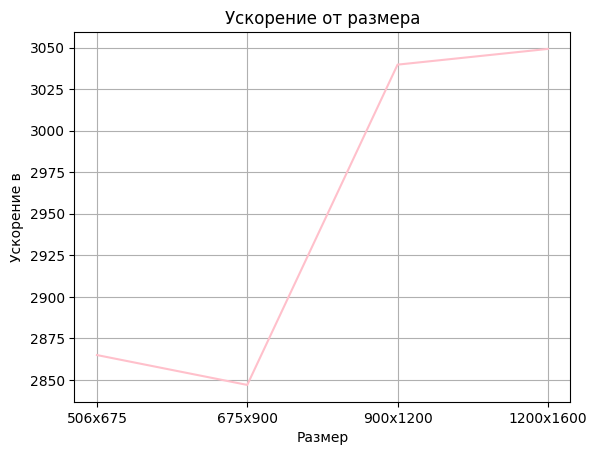

In [56]:
plt.cla()
plt.title('Ускорение от размера')
plt.xlabel('Размер')
plt.ylabel('Ускорение в')
accel = []
for i in range (len(time_cpu)):
  accel.append(time_cpu[i]/time_gpu[i])

plt.plot(size,accel,'pink')
plt.grid(True)
plt.show()

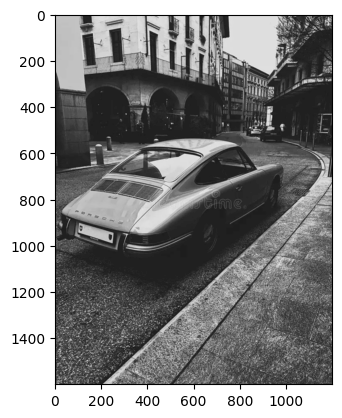

In [47]:
# 506x675 675x900 900x1200 1200x1600

img = Image.fromarray(image_1, mode="L")
image_4 = img.resize((1200, 1600))

image_4.save('image_4.bmp')
plt.imshow(image_4, cmap='gray')